In [4]:
import utils
from utils import *

In [5]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\lucas\\DataScience\\l3stockmdl\\utils.py'>

In [6]:
#df, meta_data = get_data('PETR4.SA.SAO')
#print(meta_data)

df = pd.read_csv('./databases/PETR4_2024-10-25.csv')
df = stock_feature_prep(df)

lgbm, best_params, best_score, y_pred, y_val = modeling(df)
df['predicted'] = lgbm.predict(df[lgbm.feature_name_])

from sklearn.metrics import r2_score, mean_squared_error

# Calculate R2 score
r2 = r2_score(y_val, y_pred)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2, rmse

(0.9991316921385587, 0.019327376366482046)

In [7]:
lgbm_feat_imp = lgbm.feature_importances_ / lgbm.feature_importances_.sum()

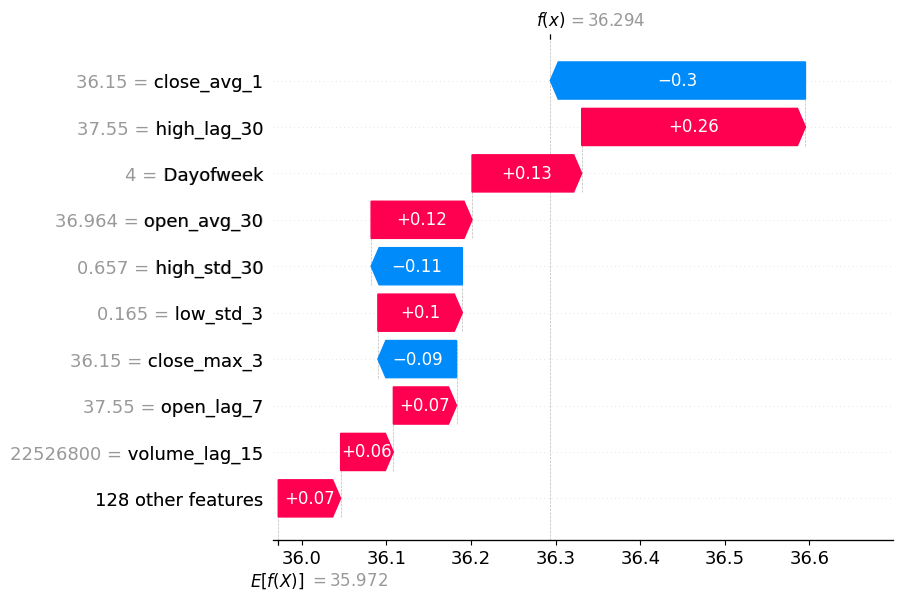

In [33]:
import shap
import matplotlib.pyplot as plt
import streamlit.components.v1 as components

temp = df[lgbm.feature_name_].tail(1)

def st_shap(plot, height=None):
    shap_html = f"<head>{shap.getjs()}</head><body>{plot.html()}</body>"
    components.html(shap_html, height=height)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(temp[lgbm.feature_name_])
# Create a DataFrame for SHAP values
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=temp.iloc[0]))

In [ ]:
import plotly.express as px

# Get feature names

# Create a DataFrame for feature importances
feat_imp_df = pd.DataFrame({'Feature': lgbm.feature_name_ , 'Importance': lgbm_feat_imp})

# Sort by importance
temp = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)
temp.sort_values(by='Importance', inplace=True)

# Plot using Plotly
fig = px.bar(temp, x='Importance', y='Feature', orientation='h', title='Top 10 Feature Importances')
fig.show()

In [8]:
import joblib
# Save model
# joblib.dump(lgbm, f'./mdl_versions/PETR4_2024-09-13.joblib')

In [9]:
import plotly.graph_objects as go

df.sort_values('date', inplace=True)
temp = df[df['date'] > '2024-07-01']

# Create a Plotly figure
fig = go.Figure()

# Add observed data
fig.add_trace(go.Scatter(x=temp['date'], y=temp['target'], mode='lines', name='Observed', line=dict(color='orange')))

# Add predicted data
fig.add_trace(go.Scatter(x=temp['date'], y=temp['predicted'], mode='lines', name='Predicted', line=dict(color='orange', dash='dash')))

# Update layout
fig.update_layout(
    title='Stock Close Price per Day',
    xaxis_title='Date',
    yaxis_title='Close Price',
    legend=dict(x=0, y=1)
)

# Display the Plotly figure using Streamlit
fig.show()

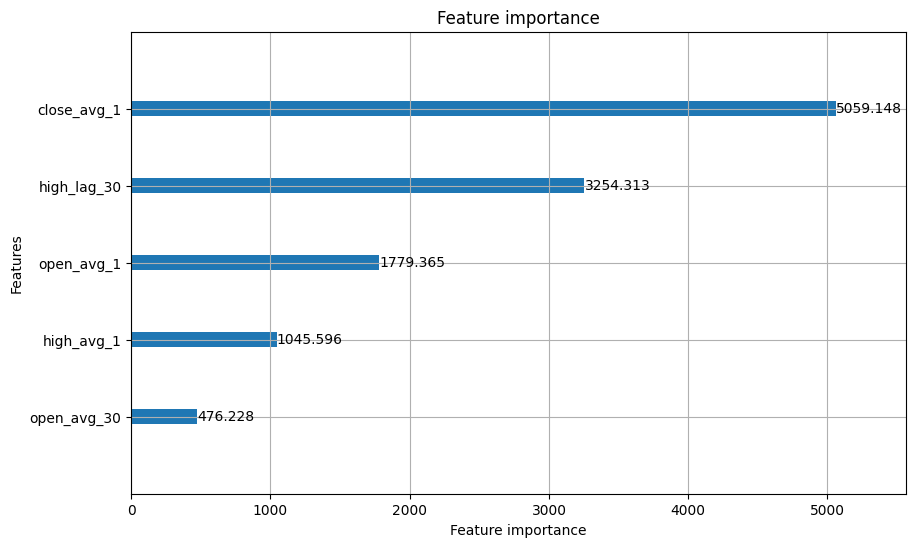

In [10]:
# Assuming you have a trained LightGBM model named 'lgbm'
lgb.plot_importance(lgbm, importance_type='gain', figsize=(10, 6), max_num_features=5)
plt.show()

In [11]:
prediction = round(df[df['date'] == df['date'].max()]['predicted'].values[0], 3)

In [12]:
last_day_value = round(df[df['date'] == df['date'].max() - pd.DateOffset(days=1)]['target'].values[0], 3)

In [13]:
prediction

36.294

In [14]:
last_day_value

36.15

In [15]:
if prediction > last_day_value:
    print(f'The stock price will increase by {round(prediction - last_day_value, 3)}')

The stock price will increase by 0.144


In [16]:
last_day = round(df[df['date'] == df['date'].max()]['predicted'].values[0], 3)
